일단 환승정보 반영 안 함

In [4]:
import pandas as pd

df1 = pd.read_csv('메인C조train_data/train_subway21_mov1.csv').sample(n=50000, random_state=42)
df2 = pd.read_csv('메인C조train_data/train_subway22_mov1.csv').sample(n=50000, random_state=42)
df3 = pd.read_csv('메인C조train_data/train_subway23_mov1.csv').sample(n=50000, random_state=42)

In [5]:
df1.columns = df1.columns.str.replace('train_subway21.', '', regex=False)
df2.columns = df2.columns.str.replace('train_subway22.', '', regex=False)
df3.columns = df3.columns.str.replace('train_subway23.', '', regex=False)

In [6]:
print(f'df1: {len(df1)}\ndf2: {len(df2)}\ndf3: {len(df3)}')
df = pd.concat([df1, df2, df3])
len(df)

df1: 50000
df2: 50000
df3: 50000


150000

In [7]:
import torch

In [8]:
# import pandas as pd
# df = pd.read_csv('메인C조train_data\\train_subway23.csv')
# df.columns = df.columns.str.replace('train_subway23.', '', regex=False)

In [9]:
df['date'] = df['month'].astype(str) + '-' + df['day'].astype(str)

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['direction'] = le.fit_transform(df['direction'])

In [11]:
locdf = pd.read_csv('서울시 역사마스터 정보.csv', encoding="euc-kr")

In [12]:
locdf = locdf.rename(columns={
    '역사_ID': 'station_number',
    '위도': 'lat',
    '경도': 'lon'
})[['station_number', 'lat', 'lon']]

In [13]:
df = pd.merge(df, locdf, on='station_number', how='left')
df = df.dropna(subset=['lat', 'lon']).reset_index(drop=True)

In [ ]:
import networkx as nx

G = nx.Graph()

# 1. 노드 추가
for _, row in df.iterrows():
    node_id = f"{row['station_number']}_{row['date']}_{row['hour']}"
    if node_id not in G:
        G.add_node(node_id, features=[], lat=row['lat'], lon=row['lon'])

    G.nodes[node_id]['features'].append([
        row['congestion'],
        row['hour'],          
        row['weekday'],
        row['direction'],
        row['stn'],
        row['ta'],
        row['wd'],
        row['ws'],
        row['rn_day'],
        row['rn_hr1'],
        row['hm'],
        row['si'],
        row['ta_chi'],
        row['lat'],
        row['lon'],
        # 'is_weekday', 'rush_hour'
        row['is_weekday'],
        row['rush_hour']
    ])

    G.nodes[node_id]['y'] = row['congestion']

station_ids = sorted(df['station_number'].unique())

# 같은 역의 인접 시간대 연결
for station in df['station_number'].unique():
    df_station = df[df['station_number'] == station].sort_values(['date','hour'])
    prev_node = None

    for _, row in df_station.iterrows():
        curr_node = f"{row['station_number']}_{row['date']}_{row['hour']}"

        if prev_node and curr_node in G and prev_node in G:
            G.add_edge(prev_node, curr_node, edge_type='time_transition')

        prev_node = curr_node

invalid_nodes = [n for n in G.nodes if 'features' not in G.nodes[n]]
print(invalid_nodes)
G.remove_nodes_from(invalid_nodes)

for n in G.nodes:
    feature_list = G.nodes[n]['features']
    G.nodes[n]['x'] = torch.tensor(feature_list).float().mean(dim=0)
    G.nodes[n]['y'] = torch.tensor(G.nodes[n]['y']).float()

[]


In [15]:
df['node_id'] = df['station_number'].astype(str) + '_' +df['date'].astype(str) + '_'+ df['hour'].astype(str)
print(df['node_id'].nunique())
print(sorted(df['node_id'].unique())[:10])

149317
['1002_2021-01-10_23', '1002_2021-01-12_21', '1002_2021-01-14_15', '1002_2021-01-15_8', '1002_2021-01-18_9', '1002_2021-01-1_12', '1002_2021-01-1_19', '1002_2021-01-20_10', '1002_2021-01-20_14', '1002_2021-01-21_14']


In [16]:
# 얘가 개오래걸림
from torch_geometric.utils import from_networkx
import torch
from multiprocessing import Pool, cpu_count
from tqdm.auto import tqdm 

node_features = {n: G.nodes[n]['x'].clone().detach().float() for n in G.nodes}
node_list = list(G.nodes)
x_values = [node_features[n] for n in node_list] 

node_to_congestion = dict(zip(df['node_id'], df['congestion']))

data = from_networkx(G)
data.x = torch.stack(x_values)
data.y = torch.tensor([node_to_congestion[n] for n in node_list], dtype=torch.float32)

print(data)
print(data.y.shape)

Data(x=[149317, 16], edge_index=[2, 345755], y=[149317], features=[149317], lat=[149317], lon=[149317], edge_type=[345755])
torch.Size([149317])


KeyboardInterrupt: 

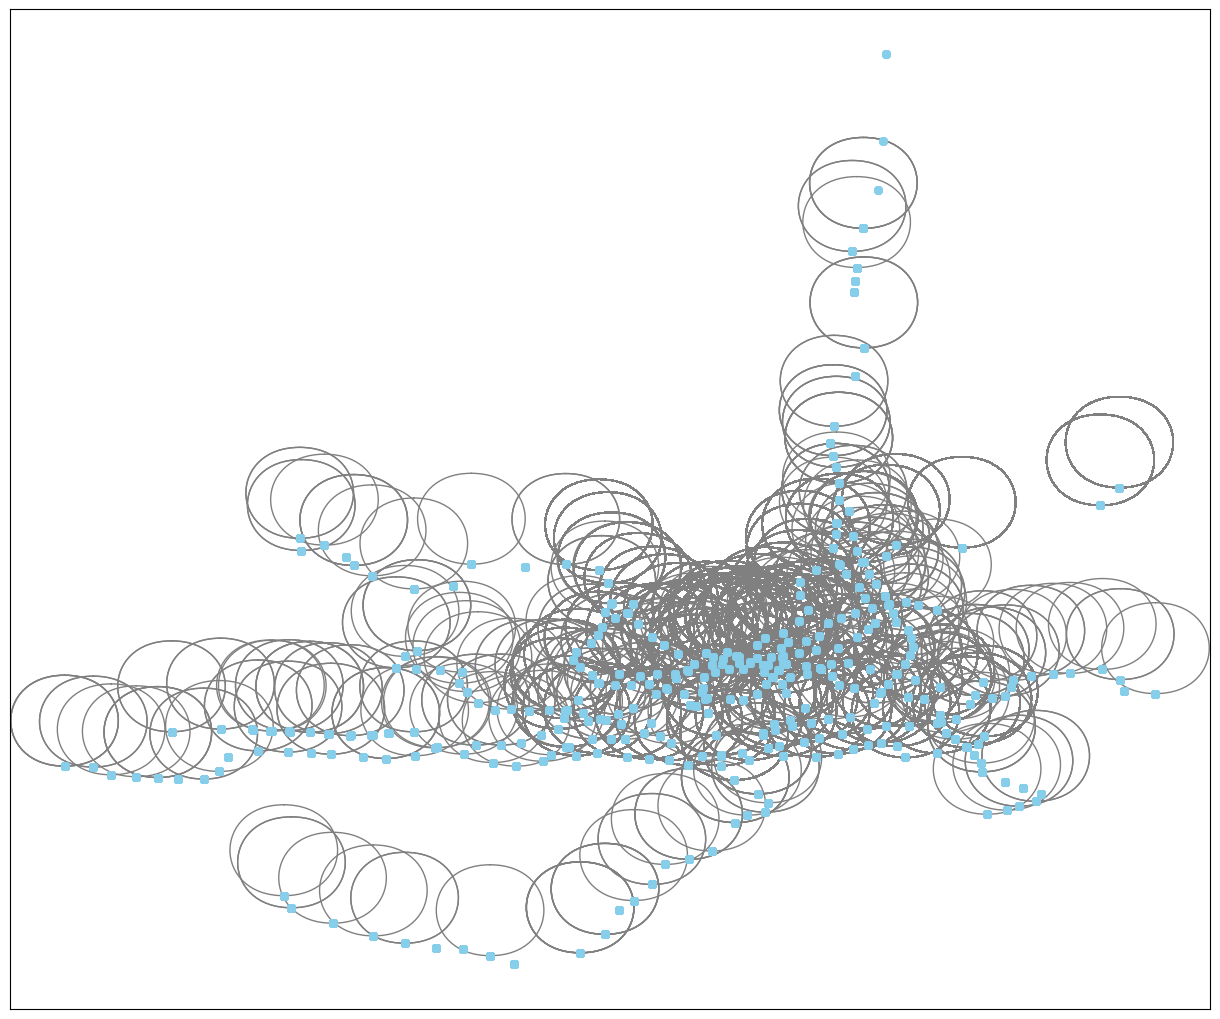

In [17]:
import networkx as nx
import matplotlib.pyplot as plt

valid_nodes = {n for n in G.nodes if G.nodes[n]['lat'] is not None and G.nodes[n]['lon'] is not None}
pos = {n: (G.nodes[n]['lon'], G.nodes[n]['lat']) for n in valid_nodes}
H = G.subgraph(valid_nodes)

# 1. 좌표 딕셔너리 생성 (pos는 {node_id: (lon, lat)} 형태)
pos = {node: (attr['lon'], attr['lat']) for node, attr in G.nodes(data=True)}

# 2. 그림 그리기
plt.figure(figsize=(12, 10))
nx.draw(
    G,
    pos=pos,
    with_labels=True,
    node_size=30,
    font_size=6,
    edge_color='gray',
    node_color='skyblue'
)
plt.title("Seoul metro - lat/lon")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [18]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.metrics import mean_squared_error
import torch.nn as nn

In [19]:
# hyperparameters 

In [20]:
class GCNRegressor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.linear = nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        out = self.linear(x)
        return out.squeeze()

In [21]:
# from torch_geometric.utils import subgraph
# import torch
# from torch_geometric.data import Data

# def extract_subgraph(data, node, target):
#     node_msk = (node == target)
#     node_idx = node_msk.nonzero(as_tuple = True)[0]
#     edge_idx, edge_msk = subgraph(node_idx, data.edge_index, relabel_nodes=True)
#     x_sub = data.x[node_idx]
#     y_sub = data.y[node_idx]

#     sub_data = Data(x=x_sub, edge_idx = edge_idx, y=y_sub)
#     return sub_data

In [22]:
print(len(df))         # DataFrame 전체 행 수
print(data.x.shape[0]) # PyG 데이터의 노드 수

197632
149317


In [ ]:
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
results = {}

data = data.to(device)

num_nodes = data.x.shape[0]
idx = torch.arange(num_nodes)

train_idx, val_idx = train_test_split(idx.cpu().numpy(), test_size=0.2, random_state=42)
train_idx = torch.tensor(train_idx).to(device)
val_idx = torch.tensor(val_idx).to(device)

model = GCNRegressor(in_channels=data.x.shape[1], hidden_channels=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

for epoch in range(1, 1001):
    model.train()
    optimizer.zero_grad()

    out = model(data.x, data.edge_index)  
    loss = loss_fn(out[train_idx], data.y[train_idx])
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        model.eval()
        with torch.no_grad():
            y_train = data.y[train_idx].cpu().numpy()
            y_pred_train = out[train_idx].cpu().numpy().squeeze()
            train_rmse = root_mean_squared_error(y_train, y_pred_train)
            train_r2 = r2_score(y_train, y_pred_train)

            y_val = data.y[val_idx].cpu().numpy()
            y_pred_val = out[val_idx].cpu().numpy().squeeze()
            val_rmse = root_mean_squared_error(y_val, y_pred_val)
            val_r2 = r2_score(y_val, y_pred_val)

            print(f"[Epoch {epoch:03d}] Train RMSE: {train_rmse:.4f}, R²: {train_r2:.4f} | Val RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}")

results['full'] = out.detach().cpu()


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 020] Train RMSE: 19.6059, R²: -0.0331 | Val RMSE: 19.5157, R²: -0.0289


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 040] Train RMSE: 19.6705, R²: -0.0399 | Val RMSE: 19.5972, R²: -0.0375


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 060] Train RMSE: 19.3946, R²: -0.0110 | Val RMSE: 19.3212, R²: -0.0085


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 080] Train RMSE: 19.2417, R²: 0.0049 | Val RMSE: 19.1821, R²: 0.0060


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 100] Train RMSE: 19.1918, R²: 0.0101 | Val RMSE: 19.1353, R²: 0.0108


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 120] Train RMSE: 19.1481, R²: 0.0146 | Val RMSE: 19.0917, R²: 0.0153


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 140] Train RMSE: 19.0434, R²: 0.0253 | Val RMSE: 18.9890, R²: 0.0259


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 160] Train RMSE: 18.9265, R²: 0.0373 | Val RMSE: 18.8751, R²: 0.0375


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 180] Train RMSE: 18.8428, R²: 0.0458 | Val RMSE: 18.7930, R²: 0.0459


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 200] Train RMSE: 18.7890, R²: 0.0512 | Val RMSE: 18.7415, R²: 0.0511


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 220] Train RMSE: 18.7529, R²: 0.0548 | Val RMSE: 18.7067, R²: 0.0546


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 240] Train RMSE: 18.7260, R²: 0.0575 | Val RMSE: 18.6811, R²: 0.0572


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 260] Train RMSE: 18.7032, R²: 0.0598 | Val RMSE: 18.6606, R²: 0.0593


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 280] Train RMSE: 18.6832, R²: 0.0618 | Val RMSE: 18.6428, R²: 0.0611


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 300] Train RMSE: 18.6640, R²: 0.0638 | Val RMSE: 18.6254, R²: 0.0628


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 320] Train RMSE: 18.6461, R²: 0.0656 | Val RMSE: 18.6087, R²: 0.0645


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 340] Train RMSE: 18.6300, R²: 0.0672 | Val RMSE: 18.5941, R²: 0.0660


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 360] Train RMSE: 18.6148, R²: 0.0687 | Val RMSE: 18.5803, R²: 0.0674


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 380] Train RMSE: 18.5954, R²: 0.0706 | Val RMSE: 18.5611, R²: 0.0693


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 400] Train RMSE: 18.5745, R²: 0.0727 | Val RMSE: 18.5433, R²: 0.0711


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 420] Train RMSE: 18.5558, R²: 0.0746 | Val RMSE: 18.5290, R²: 0.0725


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 440] Train RMSE: 18.5413, R²: 0.0760 | Val RMSE: 18.5173, R²: 0.0737


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 460] Train RMSE: 18.5282, R²: 0.0773 | Val RMSE: 18.5075, R²: 0.0747


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 480] Train RMSE: 18.5152, R²: 0.0786 | Val RMSE: 18.4960, R²: 0.0758


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 500] Train RMSE: 18.5057, R²: 0.0796 | Val RMSE: 18.4905, R²: 0.0764


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 520] Train RMSE: 18.4907, R²: 0.0811 | Val RMSE: 18.4761, R²: 0.0778


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 540] Train RMSE: 18.4811, R²: 0.0820 | Val RMSE: 18.4683, R²: 0.0786


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 560] Train RMSE: 18.4685, R²: 0.0833 | Val RMSE: 18.4563, R²: 0.0798


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 580] Train RMSE: 18.4586, R²: 0.0843 | Val RMSE: 18.4455, R²: 0.0809


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 600] Train RMSE: 18.4454, R²: 0.0856 | Val RMSE: 18.4345, R²: 0.0820


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 620] Train RMSE: 18.4365, R²: 0.0865 | Val RMSE: 18.4277, R²: 0.0826


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 640] Train RMSE: 18.4239, R²: 0.0877 | Val RMSE: 18.4155, R²: 0.0838


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 660] Train RMSE: 18.4135, R²: 0.0887 | Val RMSE: 18.4046, R²: 0.0849


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 680] Train RMSE: 18.4014, R²: 0.0899 | Val RMSE: 18.3941, R²: 0.0860


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 700] Train RMSE: 18.3939, R²: 0.0907 | Val RMSE: 18.3896, R²: 0.0864


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 720] Train RMSE: 18.3800, R²: 0.0921 | Val RMSE: 18.3752, R²: 0.0878


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 740] Train RMSE: 18.3726, R²: 0.0928 | Val RMSE: 18.3674, R²: 0.0886


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 760] Train RMSE: 18.3589, R²: 0.0941 | Val RMSE: 18.3561, R²: 0.0897


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 780] Train RMSE: 18.3481, R²: 0.0952 | Val RMSE: 18.3475, R²: 0.0906


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 800] Train RMSE: 18.3408, R²: 0.0959 | Val RMSE: 18.3429, R²: 0.0911


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 820] Train RMSE: 18.3273, R²: 0.0972 | Val RMSE: 18.3286, R²: 0.0925


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 840] Train RMSE: 18.3169, R²: 0.0983 | Val RMSE: 18.3193, R²: 0.0934


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 860] Train RMSE: 18.3149, R²: 0.0985 | Val RMSE: 18.3153, R²: 0.0938


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 880] Train RMSE: 18.2947, R²: 0.1005 | Val RMSE: 18.3013, R²: 0.0952


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 900] Train RMSE: 18.2822, R²: 0.1017 | Val RMSE: 18.2894, R²: 0.0963


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 920] Train RMSE: 18.2697, R²: 0.1029 | Val RMSE: 18.2751, R²: 0.0978


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 940] Train RMSE: 18.2605, R²: 0.1038 | Val RMSE: 18.2655, R²: 0.0987


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 960] Train RMSE: 18.2508, R²: 0.1048 | Val RMSE: 18.2618, R²: 0.0991


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Epoch 980] Train RMSE: 18.2347, R²: 0.1063 | Val RMSE: 18.2440, R²: 0.1008
[Epoch 1000] Train RMSE: 18.2373, R²: 0.1061 | Val RMSE: 18.2454, R²: 0.1007


C:\Users\tlatp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [25]:
print("congestion 평균:", data.y.mean().item())
print("congestion 표준편차:", data.y.std().item())
print("congestion 최소~최대:", data.y.min().item(), "~", data.y.max().item())

congestion 평균: 21.496688842773438
congestion 표준편차: 19.279407501220703
congestion 최소~최대: 0.0 ~ 236.0


## test sample 전처리

In [26]:
test = pd.read_csv('test_sample.csv', encoding='utf-8')
len(test)

5834752

In [27]:
test.columns = test.columns.str.replace('train_subway23.', '', regex=False)

In [28]:
test.head(2)

,datetime,tm,line,station_number,station_name,direction,stn,ta,wd,ws,...,datetime,weekday,is_weekday,year,month,day,hour,rush_hour,station_name_encoded,direction_bin
0,2024-01-01 00:00:00,2024010100,1,150,서울역,상선,419,0.6,159.482862,2.7,...,2024-01-01 00:00:00,0,1,2024,2024-01,1,0,0,167,0
1,2024-01-01 01:00:00,2024010101,1,150,서울역,상선,419,0.0,163.643530,3.8,...,2024-01-01 01:00:00,0,1,2024,2024-01,1,1,0,167,0


In [29]:
test['date'] = test['month'].astype(str) + '-' + test['day'].astype(str)

test['direction'] = le.fit_transform(test['direction'])

locdf = pd.read_csv('서울시 역사마스터 정보.csv', encoding="euc-kr")
locdf = locdf.rename(columns={
    '역사_ID': 'station_number',
    '위도': 'lat',
    '경도': 'lon'
})[['station_number', 'lat', 'lon']]


test = pd.merge(test, locdf, on='station_number', how='left')
test = test.dropna(subset=['lat', 'lon']).reset_index(drop=True)

In [30]:
test_G = nx.Graph()

# 1. 노드 추가
for _, row in test.iterrows():
    node_id = f"{row['station_number']}_{row['date']}_{row['hour']}"
    if node_id not in test_G:
        test_G.add_node(node_id, features=[], lat=row['lat'], lon=row['lon'])

    test_G.nodes[node_id]['features'].append([
        row['hour'],          
        row['weekday'],
        row['direction'],
        row['stn'],
        row['ta'],
        row['wd'],
        row['ws'],
        row['rn_day'],
        row['rn_hr1'],
        row['hm'],
        row['si'],
        row['ta_chi'],
        row['lat'],
        row['lon'],
        row['is_weekday'],
        row['rush_hour']
    ])

    test_G.nodes[node_id]['y'] = row['congestion']

station_ids = sorted(test['station_number'].unique())

# 같은 역의 인접 시간대 연결
for station in test['station_number'].unique():
    test_station = test[test['station_number'] == station].sort_values(['date','hour'])
    prev_node = None

    for _, row in test_station.iterrows():
        curr_node = f"{row['station_number']}_{row['date']}_{row['hour']}"

        if prev_node and curr_node in test_G and prev_node in test_G:
            test_G.add_edge(prev_node, curr_node, edge_type='time_transition')

        prev_node = curr_node

invalid_nodes = [n for n in test_G.nodes if 'features' not in test_G.nodes[n]]
print(invalid_nodes)
test_G.remove_nodes_from(invalid_nodes)

for n in test_G.nodes:
    feature_list = test_G.nodes[n]['features']
    test_G.nodes[n]['x'] = torch.tensor(feature_list).float().mean(dim=0)
    test_G.nodes[n]['y'] = torch.tensor(test_G.nodes[n]['y']).float()

[]


In [31]:
test['node_id'] = test['station_number'].astype(str) + '_' +test['date'].astype(str) + '_'+ test['hour'].astype(str)
print(test['node_id'].nunique())
print(sorted(test['node_id'].unique())[:10])

2917376
['1002_2024-01-10_0', '1002_2024-01-10_1', '1002_2024-01-10_10', '1002_2024-01-10_11', '1002_2024-01-10_12', '1002_2024-01-10_13', '1002_2024-01-10_14', '1002_2024-01-10_15', '1002_2024-01-10_16', '1002_2024-01-10_17']


In [32]:
node_features = {n: test_G.nodes[n]['x'].clone().detach().float() for n in test_G.nodes}
node_list = list(test_G.nodes)
x_values = [node_features[n] for n in node_list] 

node_to_congestion = dict(zip(test['node_id'], test['congestion']))

tdata = from_networkx(G)
tdata.x = torch.stack(x_values)
tdata.y = torch.tensor([node_to_congestion[n] for n in node_list], dtype=torch.float32)

print(tdata)
print(tdata.y.shape)

Data(x=[2917376, 16], edge_index=[2, 345755], y=[2917376], features=[149317], lat=[149317], lon=[149317], edge_type=[345755])
torch.Size([2917376])


In [33]:
model.eval()
with torch.no_grad():
    y_pred_all = model(tdata.x.to(device), tdata.edge_index.to(device)).cpu().numpy().squeeze()


node_order = list(test_G.nodes)

pred_df = pd.DataFrame({
    'node_id': node_order,
    'congestion_pred': y_pred_all
})

In [34]:
test = test.merge(pred_df, on='node_id', how='left')
test['congestion'] = test['congestion'].fillna(test['congestion_pred'])
test = test.drop(columns=['congestion_pred'])

In [35]:
test.head(2)

,datetime,tm,line,station_number,station_name,direction,stn,ta,wd,ws,...,month,day,hour,rush_hour,station_name_encoded,direction_bin,date,lat,lon,node_id
0,2024-01-01 00:00:00,2024010100,1,150,서울역,1,419,0.6,159.482862,2.7,...,2024-01,1,0,0,167,0,2024-01-1,37.554648,126.972559,150_2024-01-1_0
1,2024-01-01 00:00:00,2024010100,1,150,서울역,1,419,0.6,159.482862,2.7,...,2024-01,1,0,0,167,0,2024-01-1,37.556228,126.972135,150_2024-01-1_0


In [37]:
test[['congestion']].to_csv('test_validation.csv', index=False)